In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
labels=os.listdir("../../data/raw/01_kaggle_dataset/dataset_new/train")
labels

['Closed', 'no_yawn', 'Open', 'yawn']

(145, 145, 3)

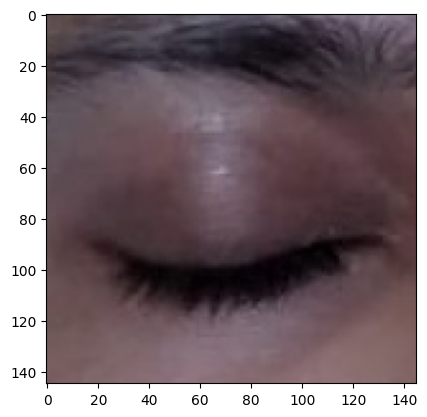

In [3]:
ce=plt.imread("../../data/raw/01_kaggle_dataset/dataset_new/train/Closed/_0.jpg")
plt.imshow(ce)
ce.shape

(98, 157, 3)

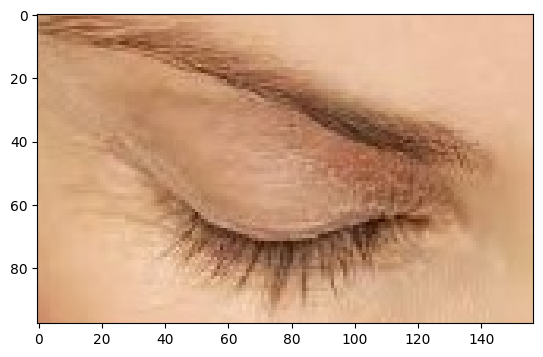

In [4]:
ce2=plt.imread("../../data/raw/01_kaggle_dataset/dataset_new/test/Closed/_634.jpg")
plt.imshow(ce2)
ce2.shape

(480, 640, 3)

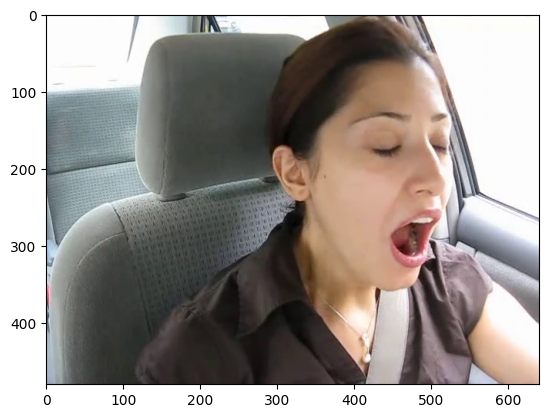

In [5]:
y=plt.imread("../../data/raw/01_kaggle_dataset/dataset_new/train/yawn/1.jpg")
plt.imshow(y)
y.shape

이미지들의 크기가 다 다르다.  
따라서 이미지의 크기를 다 일치시켜야 한다.  

# 얼굴 인식 - Haar Casecades
먼저 Yawn(하품) 이미지를 OpenCV로 얼굴 인식해야 한다.  
OpenCV에서 제공하는 얼굴, 눈 등에 대한 미리 훈련된 데이터인 Haar Casecades라는 것이 존재한다.  
자세한 내용은 아래를 참고하자.  
- https://deep-learning-study.tistory.com/244  

또, 이 캐스케이드 분류기 함수 `cv2.CascadeClassifier`, `detectMultiScale` 을 사용하기 위해서는 아래 링크에서 `haarcascade_frontalface_default.xml` 파일을 다운받아야 한다.  
- https://github.com/opencv/opencv/tree/master/data/haarcascades

In [6]:
BASE_DIR="../../data/raw/01_kaggle_dataset/dataset_new"
SAVE_DIR="../../data/processed/01_kaggle_dataset/cropped_dataset_HARR"

FACE_CAS_PATH="../../data/raw/01_kaggle_dataset/haarcascade_frontalface_default.xml"
face_cascade=cv2.CascadeClassifier(FACE_CAS_PATH)

IMG_SIZE=145  # 리사이즈 크기(눈 이미지와 크기 맞추기)
categories=["Closed", "Open", "no_yawn", "yawn"]

def crop_and_save(dataset_type):  # train, test
    src_path=os.path.join(BASE_DIR, dataset_type)  # dataset_new/train, dataset_new/test
    dst_path=os.path.join(SAVE_DIR, dataset_type)  # cropped_dataset_HARR/train, cropped_dataset_HARR/test

    for category in categories:  # Closed, Open, no_yawn, yawn
        # dataset_new/train/Closed, dataset_new/train/Open, dataset_new/train/no_yawn, dataset_new/train/yawn
        src_class_path=os.path.join(src_path, category)
        # cropped_dataset_HARR/train/Closed, cropped_dataset_HARR/train/Open, cropped_dataset_HARR/train/no_yawn, cropped_dataset_HARR/train/yawn
        dst_class_path=os.path.join(dst_path, category)
        os.makedirs(dst_class_path, exist_ok=True)

        for img_name in tqdm(os.listdir(src_class_path), desc=f"Processing {category}", ncols=100):
            img_path=os.path.join(src_class_path, img_name)
            img_array=cv2.imread(img_path, cv2.IMREAD_COLOR)

            if img_array is None: continue  # IMG load fail -> skip

            # cv2.CascadeClassifier.detectMultiScale(image, scaleFactor, minNeighbors, minSize, maxSize) -> result
            # image: 입력
            # scaleFactor: 축소 비율 (default: 1.1) -> 1.3 -> 너무 작으면 연산량 커지고, 너무 크면 작은 얼굴을 놓침
            # minNeighbors: 얼마나 많은 이웃 사각형이 검출되어야 최종 검출 영역으로 설정할지(default: 3) -> 5
            #               얼굴 아닌 걸 얼굴로 착각하는 걸 방지 → 값이 낮으면 오탐 많고, 높으면 놓침 많아짐 (3~6 정도가 적절)
            # minSize, maxSize: 최소, 최대 객체 크기 (w, h)
            # result: 검출된 객체의 사격형 정보(x,y,w,h)를 담은 numpy 배열
            faces=face_cascade.detectMultiScale(img_array, scaleFactor=1.3, minNeighbors=5)

            if len(faces)==0: continue  # 얼굴 못 찾은 경우 스킵

            # 가장 큰 얼굴 1개만 crop하여 저장(여러 명이 찍힌 경우도 안정적으로 처리)
            x, y, w, h=sorted(faces, key=lambda box: box[2] * box[3], reverse=True)[0]
            ROI=img_array[y:y+h, x:x+w]  # ROI(Region of Interest) 얼굴 부분만 crop
            resized=cv2.resize(ROI, (IMG_SIZE, IMG_SIZE))

            save_path=os.path.join(dst_class_path, img_name)
            cv2.imwrite(save_path, resized)

crop_and_save("train")
crop_and_save("test")

Processing yawn: 100%|████████████████████████████████████████████| 106/106 [00:02<00:00, 35.55it/s]


이를 실행하면 아래와 같이 나와야 하는데,

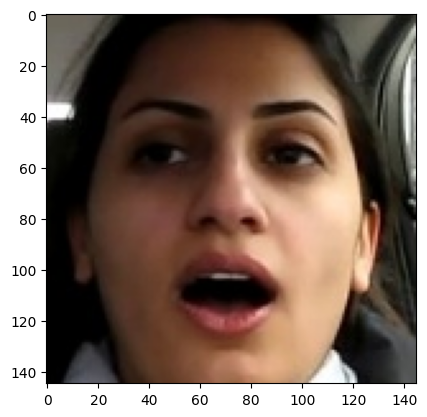

In [7]:
plt.imshow(plt.imread("../../data/processed/01_kaggle_dataset/cropped_dataset_HARR/train/yawn/241.jpg"))

꽤 많은 빈도로 제대로 인식을 못하는 경우가 있었다.  

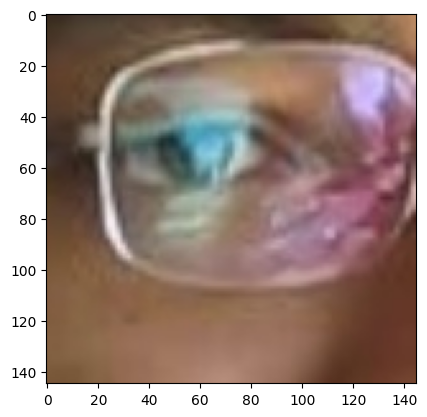

In [8]:
plt.imshow(plt.imread("../../data/processed/01_kaggle_dataset/cropped_dataset_HARR/test/no_yawn/113.jpg"))

# 얼굴 인식 2 - MediaPipe
그래서 또 다른 툴인 MediaPipe를 이용하고자 했다.  

In [9]:
# !pip install mediapipe --quiet

In [10]:
import mediapipe as mp

In [11]:
BASE_DIR="../../data/raw/01_kaggle_dataset/dataset_new"
SAVE_DIR="../../data/processed/01_kaggle_dataset/cropped_dataset_MediaPipe"
categories=["Closed", "Open", "no_yawn", "yawn"]
IMG_SIZE=145

mp_face_detection=mp.solutions.face_detection

def crop_with_mediapipe(dataset_type):  # train, test
    src_path=os.path.join(BASE_DIR, dataset_type)  # dataset_new/train, dataset_new/test
    dst_path=os.path.join(SAVE_DIR, dataset_type)  # cropped_dataset_MediaPipe/train, cropped_dataset_MediaPipe/test
    os.makedirs(dst_path, exist_ok=True)

    with mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5) as detector:
        for category in categories:
            # dataset_new/train/Closed, dataset_new/train/Open, dataset_new/train/no_yawn, dataset_new/train/yawn
            src_class_path=os.path.join(src_path, category)
            # cropped_dataset_MediaPipe/train/Closed, cropped_dataset_MediaPipe/train/Open, cropped_dataset_MediaPipe/train/no_yawn, cropped_dataset_MediaPipe/train/yawn
            dst_class_path=os.path.join(dst_path, category)
            os.makedirs(dst_class_path, exist_ok=True)

            for img_name in tqdm(os.listdir(src_class_path), desc=f"Processing {dataset_type}/{category}", ncols=100):
                img_path=os.path.join(src_class_path, img_name)
                img=cv2.imread(img_path)

                if img is None: continue  # IMG load fail -> skip

                if category in ["Closed", "Open"]:  # 145x145
                    resized=cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    save_path=os.path.join(dst_class_path, img_name)
                    cv2.imwrite(save_path, resized)
                    continue

                # yawn / no_yawn → MediaPipe crop
                img_rgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                results=detector.process(img_rgb)

                if results.detections:
                    bbox=results.detections[0].location_data.relative_bounding_box
                    h, w, _=img.shape
                    x=int(bbox.xmin * w)
                    y=int(bbox.ymin * h)
                    box_w=int(bbox.width * w)
                    box_h=int(bbox.height * h)

                    x, y=max(0, x), max(0, y)
                    face_crop=img[y:y+box_h, x:x+box_w]

                    if face_crop.shape[0] < 50 or face_crop.shape[1] < 50:
                        continue  # 너무 작은 얼굴은 스킵

                    resized=cv2.resize(face_crop, (IMG_SIZE, IMG_SIZE))
                    save_path=os.path.join(dst_class_path, img_name)
                    cv2.imwrite(save_path, resized)
                    
crop_with_mediapipe("train")
crop_with_mediapipe("test")

Processing test/yawn: 100%|██████████████████████████████████████| 106/106 [00:00<00:00, 131.70it/s]
